In [1]:
%env MKL_THREADING_LAYER=GNU


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

env: MKL_THREADING_LAYER=GNU


In [2]:
try:
    import pymc3
except:
    import pip
    pip.main(['install', 'pymc3'])
    import pymc3
    
from pymc3 import Poisson

x = Poisson.dist(mu=1)

In [3]:
samples = x.random(size=10000)

In [5]:
samples.mean()

1.0185

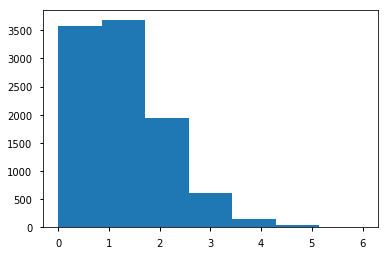

In [7]:
plt.hist(samples, bins = len(set(samples)));

In [8]:
from pymc3 import Normal

y = Normal.dist(mu=-2, sd=4)
samples = y.random(size=10000)

In [9]:
samples.mean()

-2.0304266840239338

In [10]:
samples.std()

4.0154011849746531

(array([   37.,   195.,   815.,  1992.,  2871.,  2393.,  1256.,   359.,
           73.,     9.]),
 array([-15.88819295, -12.93455202,  -9.98091109,  -7.02727017,
         -4.07362924,  -1.11998831,   1.83365262,   4.78729355,
          7.74093448,  10.6945754 ,  13.64821633]),
 <a list of 10 Patch objects>)

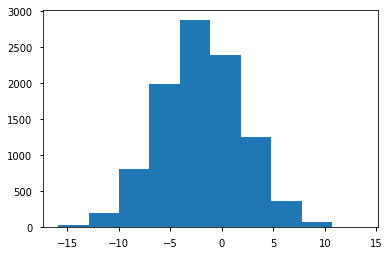

In [11]:
plt.hist(samples)

In [12]:
radon = pd.read_csv('radon.csv', index_col=0)

In [13]:
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


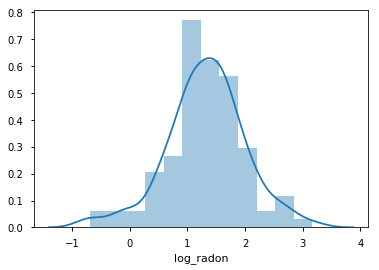

In [15]:
hennepin_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hennepin_radon)

In [16]:
hennepin_radon.shape

(105,)

In [17]:
from pymc3 import Model, Uniform

with Model() as radon_model:
    u = Normal('u', mu=0, sd=10)
    o = Uniform('o', 0, 10)

In [18]:
with radon_model:
    y = Normal('y', mu=u, sd=o, observed=hennepin_radon)

In [19]:
from pymc3 import fit
with radon_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 136.32: 100%|██████████| 10000/10000 [00:02<00:00, 4283.25it/s]
Finished [100%]: Average Loss = 136.28


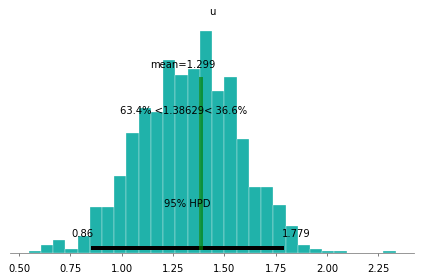

In [20]:
from pymc3 import plot_posterior

plot_posterior(samples, varnames=['u'], ref_val=np.log(4), color='LightSeaGreen')

In [21]:
mus = samples['u']
sigmas = samples['o']
mus

array([ 1.53131507,  1.56109105,  1.72234075,  1.13420831,  1.49800077,
        1.09247596,  1.55106252,  1.13013325,  1.14491412,  1.06217339,
        1.28163899,  1.00952043,  1.21003981,  1.18211037,  1.38445231,
        1.07691127,  1.24214706,  1.10377994,  1.38687618,  1.76345766,
        1.31530154,  0.90453827,  1.01818578,  1.48130426,  1.29352035,
        1.02859088,  1.29412141,  1.20021434,  0.80169626,  1.18607294,
        1.00635498,  0.86834761,  1.07085746,  1.04970186,  1.13974038,
        1.53602917,  1.73102087,  2.30512882,  1.39807538,  1.69072625,
        1.36551644,  1.26956056,  1.68738876,  1.51241919,  1.06341051,
        1.45417002,  1.52825656,  1.3529094 ,  1.27644388,  1.22694071,
        1.54603076,  1.03815693,  1.25396186,  1.48387023,  1.54661269,
        1.34727844,  0.92606102,  1.12887726,  1.40241216,  1.34276523,
        1.20281482,  2.02665289,  1.26176568,  1.59512887,  1.09456703,
        1.43280779,  1.15409063,  1.11752027,  0.51574104,  1.69

In [22]:
radon_samples = Normal.dist(mus, sigmas).random()

In [23]:
(radon_samples > np.log(4)).mean()

0.44500000000000001

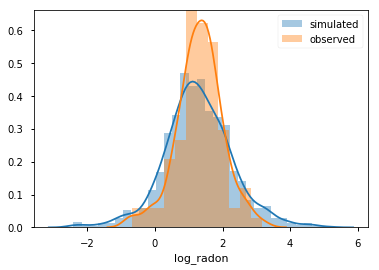

In [24]:
sns.distplot(radon_samples, label='simulated')
sns.distplot(hennepin_radon, label='observed')
plt.legend()

In [26]:
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    u = Flat('u')
    o = HalfCauchy('o', 5)
    dist = Normal('dist', mu=u, sd=o, observed = hennepin_radon)
    
    sensitivity_samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 123.98: 100%|██████████| 10000/10000 [00:02<00:00, 4582.37it/s]
Finished [100%]: Average Loss = 123.94


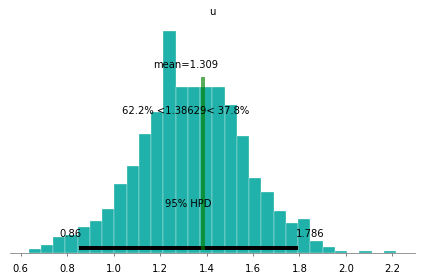

In [28]:
plot_posterior(sensitivity_samples, varnames=['u'], ref_val=np.log(4), color='LightSeaGreen')

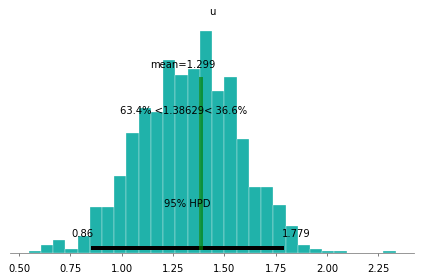

In [29]:
plot_posterior(samples, varnames=['u'], ref_val=np.log(4), color='LightSeaGreen')

In [30]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,100,109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,96,103,124,101,101,100,101,101,104,100,101), groups='drug'))

In [31]:
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,101,100,99,101,100,102,99,100,99), groups='placebo'))

In [32]:
trial_data = pd.concat([drug,placebo], ignore_index=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f537e3bf358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f537e7f9d30>], dtype=object)

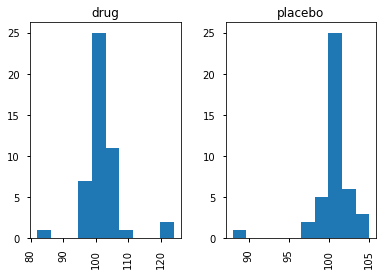

In [33]:
trial_data.hist('iq', by = 'groups')

In [34]:
from pymc3 import StudentT

In [35]:
t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0,1).random(size=10000)

(-10, 10)

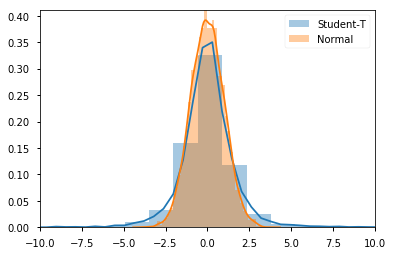

In [36]:
sns.distplot(t, label='Student-T')
sns.distplot(n, label='Normal')
plt.legend()
plt.xlim(-10,10)

In [37]:
with Model() as drug_model:
    u_0 = Normal('u_0', 100, sd=10)
    u_1 = Normal('u_1', 100, sd=10)

In [38]:
with drug_model:
    o_0 = Uniform('o_0', lower=0, upper=20)
    o_1 = Uniform('o_1', lower=0, upper=20)

In [39]:
from pymc3 import Exponential

with drug_model:
    v = Exponential('v_minus_one', 1/29.) + 1

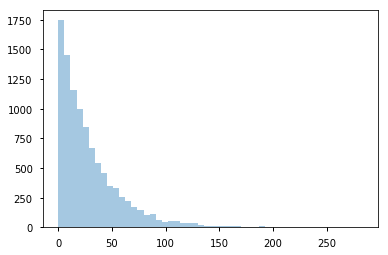

In [40]:
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False)

In [41]:
from pymc3 import StudentT

with drug_model:
    drug_like = StudentT('drug_like', nu=v, mu=u_1, lam=o_1**-2, observed = drug.iq)
    placebo_like = StudentT('placebo_like', nu=v, mu=u_0, lam=o_0**-2, observed=placebo.iq)

In [42]:
from pymc3 import Deterministic

with drug_model:
    diff_of_means = Deterministic('difference of means', u_1 - u_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((o_1**2 + o_0**2) / 2))

In [43]:
with drug_model:
    drug_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 243.4: 100%|██████████| 10000/10000 [00:03<00:00, 3171.46it/s]
Finished [100%]: Average Loss = 243.3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5378d2b320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5378c61908>], dtype=object)

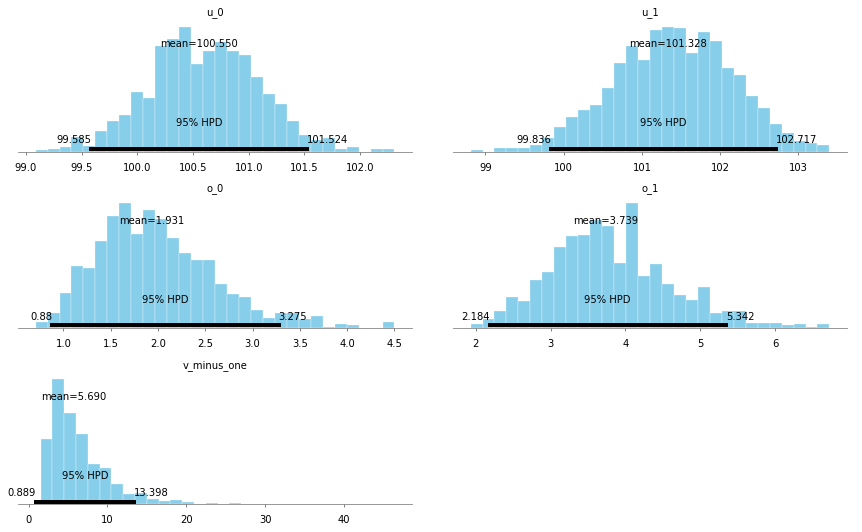

In [44]:
plot_posterior(drug_trace[100:], varnames=['u_0', 'u_1', 'o_0', 'o_1', 'v_minus_one'], color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f537895cef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f53789995f8>], dtype=object)

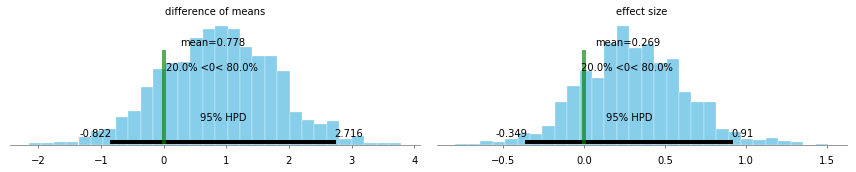

In [45]:
plot_posterior(drug_trace[100:], varnames=['difference of means', 'effect size'], ref_val = 0, color='#87ceeb')

In [46]:
nash_precip = pd.read_table('nashville_precip.txt', delimiter='\s+', na_values='NA', index_col=0)
nash_precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


In [47]:
july_rain = nash_precip.Jul
jan_rain = nash_precip.Jan

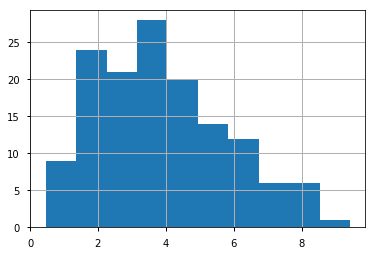

In [48]:
july_rain.hist()

In [49]:
from pymc3 import distributions
dir(distributions)

['AR',
 'AR1',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Bound',
 'Categorical',
 'Cauchy',
 'ChiSquared',
 'Constant',
 'ConstantDist',
 'Continuous',
 'DensityDist',
 'Dirichlet',
 'Discrete',
 'DiscreteUniform',
 'DiscreteWeibull',
 'Distribution',
 'ExGaussian',
 'Exponential',
 'Flat',
 'GARCH11',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'Interpolated',
 'InverseGamma',
 'LKJCholeskyCov',
 'LKJCorr',
 'Laplace',
 'Logistic',
 'Lognormal',
 'MatrixNormal',
 'Mixture',
 'Multinomial',
 'MvGaussianRandomWalk',
 'MvNormal',
 'MvStudentT',
 'MvStudentTRandomWalk',
 'NegativeBinomial',
 'NoDistribution',
 'Normal',
 'NormalMixture',
 'Pareto',
 'Poisson',
 'SkewNormal',
 'StudentT',
 'TensorType',
 'Triangular',
 'Uniform',
 'VonMises',
 'Wald',
 'Weibull',
 'Wishart',
 'WishartBartlett',
 'ZeroInflatedBinomial',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedPoisson',
 '__all__',
 '__builtins__',

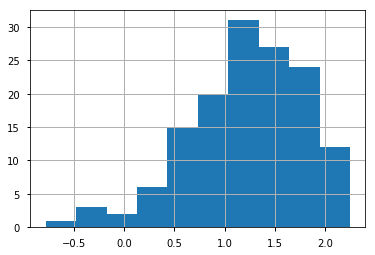

In [50]:
july_rain.apply(np.log).hist()

In [51]:
from pymc3 import Gamma

In [55]:
with Model() as rainfall_model:
    o = Uniform('o', 0, 1000)
    
    mu_jan = Uniform('mu_jan', 0, 25)
    mu_jul = Uniform('mu_jul', 0, 25)
    
    jan = Gamma('jan', mu=mu_jan, sd = o, observed = jan_rain)
    jul = Gamma('jul', mu=mu_jul, sd = o, observed = july_rain)
    
    d = Deterministic('d', mu_jan - mu_jul)

In [56]:
with rainfall_model:
    samples = fit(20000).sample(1000)

Average Loss = 910.2: 100%|██████████| 20000/20000 [00:05<00:00, 3679.24it/s]  
Finished [100%]: Average Loss = 910.14


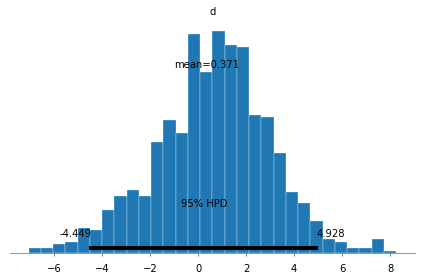

In [57]:
plot_posterior(samples, varnames=['d'])

In [58]:
vlbw = pd.read_csv('vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


In [59]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


In [60]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

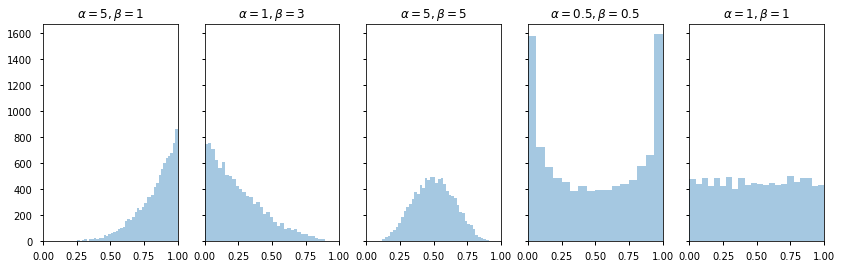

In [61]:
from pymc3 import Beta

params = (5,1), (1,3), (5,5), (0.5, 0.5), (1,1)

fig, axes = plt.subplots(1, len(params), figsize = (14,4), sharey = True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Beta.dist(alpha, beta).random(size=10000), ax=ax, kde=False)
    ax.set_xlim(0,1)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha,beta))

In [62]:
with Model() as ivh_model:
    p = Beta('p', 1, 1, shape=2)

In [63]:
from pymc3 import Bernoulli

with ivh_model:
    bb_like = Bernoulli('bb_like', p=p[x], observed = ivh)

In [64]:
with ivh_model:
    p_diff = Deterministic('p_diff', p[1] - p[0])

In [65]:
with ivh_model:
    ivh_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 226.71: 100%|██████████| 10000/10000 [00:02<00:00, 3739.85it/s]
Finished [100%]: Average Loss = 226.71


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f536b9ee908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f536b9a6438>], dtype=object)

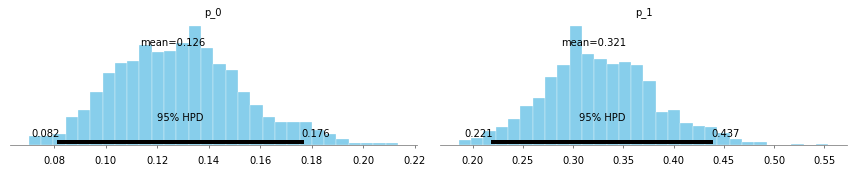

In [66]:
plot_posterior(ivh_trace[100:], varnames = ['p'], color='#87ceeb')

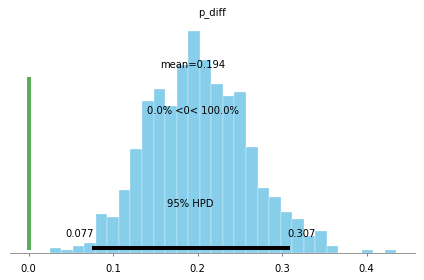

In [67]:
plot_posterior(ivh_trace[100:], varnames=['p_diff'], ref_val=0, color='#87ceeb')

In [68]:
print("Brendan McNamara")

Brendan McNamara
